# Utilizing Python for Remote Sensing Applications

Eviatar Bach ([eviatarbach@protonmail.com](mailto:eviatarbach@protonmail.com)) and Kriti Bhargava ([kritib@umd.edu](mailto:kritib@umd.edu)), based heavily on the originals by Rebekah Esmaili [bekah@umd.edu](mailto:bekah@umd.edu)

University of Maryland, College Park

## Objective: working with satellite datasets

* You won't learn how to code in Python
* You will learn to:
	* Read/write netCDF datasets
	* Plotting and visualizing the data
	* Perform re-gridding, merging, averaging, filtering
    
---

# Recap on Packages
Packages give us additional functionality, saving us the trouble of writing procedures ourselves. 

Primary libraries from the last session...
* [NumPy](http://www.numpy.org/) Fast mathematical operations on large datasets.
* [Pandas](https://pandas.pydata.org) Encapsulation of data, easy read/write of ASCII data. Builds extra functionality on top of NumPy.
* [Matplotlib](https://matplotlib.org) Primary Python plotting/visualization package. You can generate line plots, histograms, scatter plots, etc., with just a few lines of code.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Bring back our list of aeronet stations...
filename = 'Data/aeronet_locations_v3.txt'
station_list = pd.read_csv(filename, skiprows=1)
station_list.columns = ['site', 'lon', 'lat', 'elev']

## [Cartopy](https://scitools.org.uk/cartopy/)
* Cartopy is not included in Anaconda, need to install yourself.

Open the terminal (Mac/Linux) or Anaconda Prompt (Windows) and type:
```python
conda install -c conda-forge cartopy
```
* Rather than import all of Cartopy, we just want the projection classes to pair with matplotlib.
* More [map projections](https://scitools.org.uk/cartopy/docs/latest/crs/projections.html).

In [3]:
from cartopy import crs as ccrs

# Options to increase figure size
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams.update({'font.size': 16})

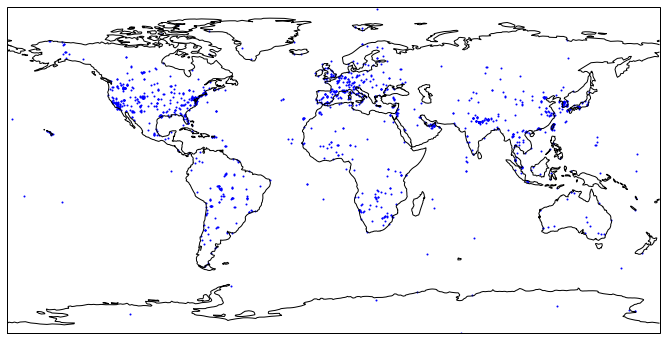

In [4]:
# Center on the Atlantic
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.scatter(station_list['lon'], station_list['lat'], color='blue', s=1)
plt.show()

<div class="alert alert-block alert-info">

**Exercise 1**

* Import aeronet_locations_v3.txt with read_csv
* Define the map axes using with option projection=ccrs.PlateCarree()
* Add coastlines
* Make a scatter plot of the station locations
* Don't forget to show the plot!

* Challenge: Shift the plot to center on -180 using ccrs.PlateCarree(central_longitude=-180)
</div>

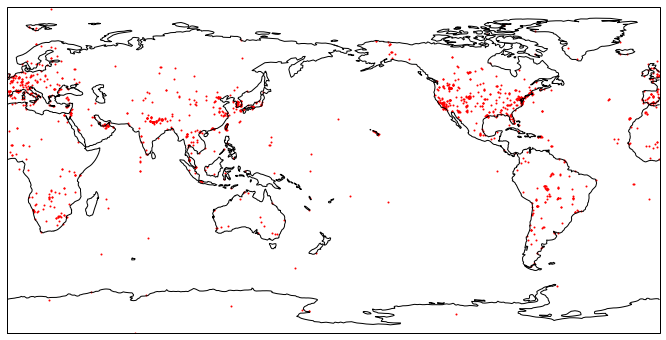

In [5]:
# Solution: Center on the Pacific (note the shift in the station longitude as well!)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-180))
ax.coastlines()
plt.scatter(station_list['lon'] - 180, station_list['lat'], color='red', s=1)
plt.show()

## [xarray](https://xarray.pydata.org/en/stable/)

* xarray is like pandas, but for N-dimensional arrays.
* Can read and write NetCDF, HDF5, and GRIB (with the additional cfgrib package) files.
* Can perform efficient operations on these datasets, including out-of-memory and parallel operations.

### LEO Example: Suomi-NPP
LEO Satellites orbit the Earth many times a day, data are organized in 1 minute swaths per file. We'll be looking at aerosol optical depth data over California.

In [6]:
import xarray

In [10]:
# Import your data...
fname = 'Data/JRR-AOD_v1r2_npp_s201811082130296_e201811082131537_c201811082228260.nc'
file_id_NPP = xarray.open_dataset(fname)

# Print a list of variables
list(file_id_NPP.variables)

['Latitude', 'Longitude', 'QCAll', 'AOD550']

In [11]:
AOD_NPP = file_id_NPP['AOD550']
lat_NPP = file_id_NPP['Latitude']
lon_NPP = file_id_NPP['Longitude']

In [12]:
# xarray has automatically read in the missing values as nan
AOD_NPP

<xarray.DataArray 'AOD550' (Rows: 768, Columns: 3200)>
[2457600 values with dtype=float32]
Coordinates:
    Latitude   (Rows, Columns) float32 ...
    Longitude  (Rows, Columns) float32 ...
Dimensions without coordinates: Rows, Columns
Attributes:
    long_name:    Aerosol optical depth at 550 nm
    units:        1
    valid_range:  [-0.05  5.  ]

In [13]:
AOD_NPP.mean()

<xarray.DataArray 'AOD550' ()>
array(0.082712, dtype=float32)

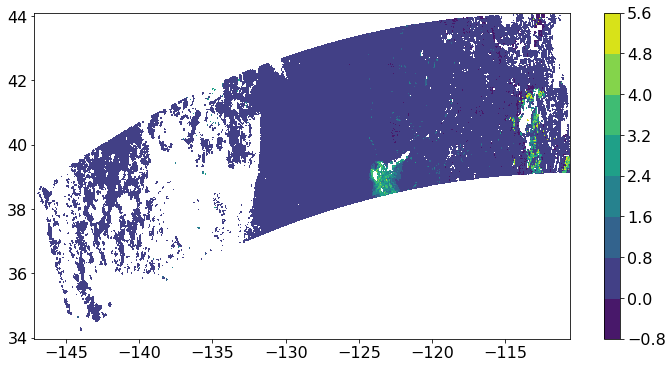

In [14]:
plt.contourf(lon_NPP, lat_NPP, AOD_NPP)
plt.colorbar()
plt.show()

In the next plot, we'll
* Add in the cartopy map
* Change the color scheme
    * See the [matplotlib color schemes](https://matplotlib.org/examples/color/colormaps_reference.html) and [ColorBrewer schemes](http://colorbrewer2.org).
    * Recommend [cmocean](https://matplotlib.org/cmocean/), a collection of colormaps for oceanography but great for other purposes too.
* There is an option to zoom in on the data using plt.xlim and plt.ylim

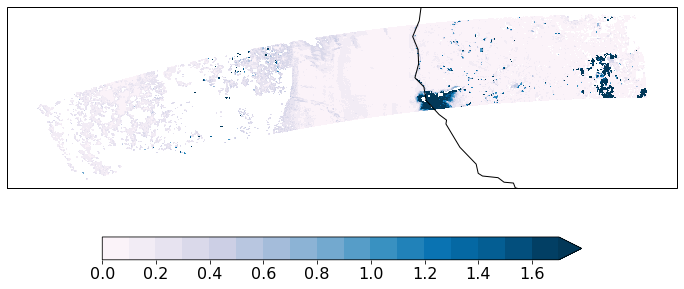

In [15]:
levs = np.arange(0, 1.8, 0.1)
img_proj = ccrs.PlateCarree()

# Using cartopy, create the map projection and plot the data
ax = plt.axes(projection=img_proj)
ax.coastlines()

# Can change color scheme using the cmap argument
plt.contourf(lon_NPP, lat_NPP, AOD_NPP, levs, transform=img_proj, extend='max',
             cmap="PuBu")

plt.colorbar(orientation="horizontal", fraction=0.07)

# To zoom in on data:
#plt.xlim(-125, -120)
#plt.ylim(38, 44)
plt.show()

<div class="alert alert-block alert-info">

**Exercise 2** 

??? = Fill in the blanks!

**Import from netCDF files**

* Import JRR-AOD_v1r1_npp_s201808091957192_e201808091958434_c201808092051240.nc using the xarray.open_dataset command.
* Inpect the available variables.
* Save the latitude, longitude, and AOD to arrays.

**Create a cartopy plot**

* Define the axes, including the projection. 
    * Challenge: Make an orthographic plot using: ccrs.Orthographic(central_longitude=-75.0, central_latitude=0.0)
* Create a plot using plt.contourf(???, ???, ???, transform=???)
    * Challenge: Change the data scale from the default to 0.0-1.6
* Remember to plt.show() at the end to display!

</div>

## Common tasks
1. Regridding
2. Masking datasets
3. Filtering with Quality Flags

### Regridding

Regridding is the process of interpolating from one grid resolution to a different grid resolution and [UCAR's website has a good discussion](https://climatedataguide.ucar.edu/climate-data-tools-and-analysis/regridding-overview). 

There are a few options:

* Interpolate using griddata from SciPy package (2D interpolate too slow/limited number of points)
* Regridding in [iris](https://scitools.org.uk/iris/docs/latest/) package (autodetection of GRIB and NC fileformats... if they follow the conventions!)
* [xESMF](https://xesmf.readthedocs.io/en/latest/), a Python package for regridding for gridded datasets (not designed for satellite data)
* __Pyresample__: the syntax can be fairly complex, but very fast

Pyresample also is not included in Anaconda, so install using:

```
conda install -c conda-forge pyresample

```

Steps:
1. Define the new grid (either in Python or import an irregular array)
2. Define the swath/satellite grid
3. Resample to get the new values for the updated grid

In [20]:
from pyresample import geometry
from pyresample.kd_tree import resample_nearest

In [21]:
# Create a new grid at 0.1 degree resolution
x = np.arange(lon_NPP.min(), lon_NPP.max(), 0.1)
y = np.arange(lat_NPP.min(), lat_NPP.max(), 0.1)
newLon, newLat = np.meshgrid(x,y)

# define the new grid using 
newLonLat = geometry.GridDefinition(lons=newLon, lats=newLat)

In [22]:
# Input list of swath points
oldLonLat = geometry.SwathDefinition(lons=lon_NPP, lats=lat_NPP)

# Resample the data
newAOD = resample_nearest(oldLonLat, AOD_NPP.values, newLonLat, radius_of_influence=5000, fill_value=None)

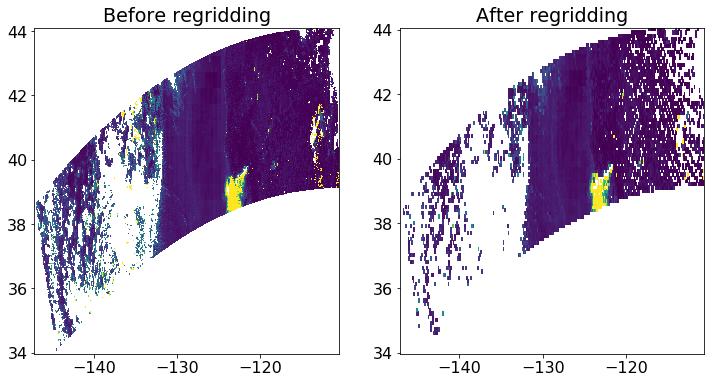

In [23]:
# To compare: Putting two plots together using plt.subplot
plt.subplot(1,2,1)
plt.title("Before regridding")
plt.pcolormesh(lon_NPP, lat_NPP, AOD_NPP, vmin=0, vmax=1)

plt.subplot(1,2,2)
plt.pcolormesh(newLon, newLat, newAOD, vmin=0, vmax=1)
plt.title("After regridding")
plt.show()

### Masking Datasets

May want to add a land/ocean mask to our datasets

In [24]:
import cartopy.feature as feature

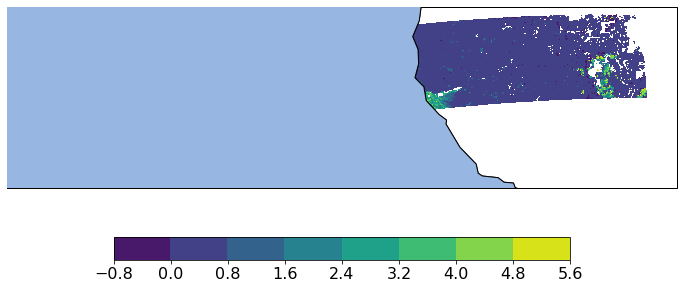

In [25]:
img_proj = ccrs.PlateCarree()

ax = plt.axes(projection=img_proj)
ax.coastlines()
plot = ax.contourf(lon_NPP, lat_NPP, AOD_NPP, transform=img_proj)

# Mask out the ocean: zorder places it on top of the existing data
ax.add_feature(feature.OCEAN, zorder=100, edgecolor='black')

cb = plt.colorbar(plot, orientation="horizontal", fraction=0.07)
plt.show()

<div class="alert alert-block alert-info">

**Exercise 3**

* Filter your plot in Exercise 2 (using NPP data) by data quality using the variable 'QCAll'
* Import QCAll into a variable
* Create a mask for medium/low quality data or pixels with no retrieval
* Make a new map with the filtered data

</div>

In [26]:
dqfNPP = file_id_NPP['QCAll']

maskHQnpp = (dqfNPP != 0)
AOD_NPP_HQ = np.ma.masked_where(maskHQnpp, AOD_NPP)

## Saving images

* Create the plot, then use plt.savefig

In [27]:
img_proj = ccrs.PlateCarree()
levs = np.arange(0, 1.8, 0.1)

ax = plt.axes(projection=img_proj)
plt.contourf(lon_NPP, lat_NPP, AOD_NPP_HQ, levs, transform=img_proj)
ax.coastlines()
plt.colorbar(orientation="horizontal", fraction=0.07)

# Add DPI option to change resolution of the plot (maintains the same aspect ratio)
plt.savefig('Figures/Wildfires_AOD_2018221_1612.png', dpi=500)

# TIP: If you want to suppress the output (runs faster!), use the following:
plt.close()

## Out-of-memory processing

* Some datasets are so big that it is not a good idea to load them all into memory.
* xarray operations can be run on successive pieces of datasets so the entire data is never in memory.

In [28]:
fname = 'Data/JRR-AOD_v1r2_npp_s201811082130296_e201811082131537_c201811082228260.nc'
file_id_NPP = xarray.open_dataset(fname, chunks=100)

In [29]:
file_id_NPP['AOD550']

<xarray.DataArray 'AOD550' (Rows: 768, Columns: 3200)>
dask.array<shape=(768, 3200), dtype=float32, chunksize=(100, 100)>
Coordinates:
    Latitude   (Rows, Columns) float32 dask.array<shape=(768, 3200), chunksize=(100, 100)>
    Longitude  (Rows, Columns) float32 dask.array<shape=(768, 3200), chunksize=(100, 100)>
Dimensions without coordinates: Rows, Columns
Attributes:
    long_name:    Aerosol optical depth at 550 nm
    units:        1
    valid_range:  [-0.05  5.  ]

In [30]:
file_id_NPP['AOD550'].mean()

<xarray.DataArray 'AOD550' ()>
dask.array<shape=(), dtype=float32, chunksize=()>

The mean does not compute! xarray will avoid doing the computation with out-of-memory datasets until you tell it to.

In [31]:
file_id_NPP['AOD550'].mean().compute()

<xarray.DataArray 'AOD550' ()>
array(0.082712, dtype=float32)

## Scripting

* Notebooks are nice for sharing results with others, but scripts are useful for automating tasks.
* You can export a script from Jupyter Notebook directly: File &rarr; Download As &rarr; Python (.py)
* To make a script, write code into a [filename].py file with the following shebang:
```python
#!/usr/bin/env python
```

For example, let's make the file `hello_world.py`:

```python
#!/usr/bin/env python

print("Hello world!")
```

Then to call the script, open the terminal, check the file permissions, and simply type:
```python
python hello_world.py
```
Windows users: you'll need to run the scripts through the Anaconda Prompt and use the full path to the script using double backslashes (\\\\). You may need to associate \*.py files with python (C:\Users\[your username]\Anaconda3\python) 


## Resources
* [PyTroll](http://pytroll.github.io) framework for the processing of Earth observation satellite data
* [Unidata AWIPS Python tutorial](http://unidata.github.io/awips2/python/satellite-imagery/)
* [Workshop on developing Python frameworks for earth system sciences](https://www.ecmwf.int/en/learning/workshops/2018-workshop-developing-python-frameworks-earth-system-sciences)
* [Python Satellite Data Analysis Toolkit (pysat)](https://github.com/rstoneback) Toolkit for space science data analysis.